Ideas:
- try different component numbers for decomp (n=10,20,30,40) - 10
- use only aggregate/decomp features
- use different normalization (standard,robust etc.)
- use different feature selection method (gbt, rfr etc.) - 750
- gridsearches on models
- stacked/averaged models

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import math

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import RobustScaler # based on percentiles and are not influened by a few very large marginal outliers
from sklearn.preprocessing import StandardScaler #removes the mean and scales the data to unit variance

from sklearn.decomposition import PCA, TruncatedSVD, NMF, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBClassifier

seed = 26

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [11]:
#### read train & test
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [18]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [19]:
test.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB
None


In [21]:
#### Check if there are any NULL values in Train Data
print("Total Train Features with NaN Values = " + str(train.columns[train.isnull().sum() != 0].size))
if (train.columns[train.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train.columns[train.isnull().sum() != 0])))
    train[train.columns[train.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0


In [22]:
#### Check if there are any NULL values in Test Data
print("Total Test Features with NaN Values = " + str(test.columns[test.isnull().sum() != 0].size))
if (test.columns[test.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test.columns[test.isnull().sum() != 0])))
    test[test.columns[test.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


In [12]:
#### Split into X,y
y_train = np.log1p(train['target'].values) #deals with 0's inverse of exp(x) - 1 or np.expm1()

train_X = train.drop(labels=['ID','target'], axis = 1)
test_X = test.drop(labels='ID', axis = 1)

In [13]:
#### Check and remove constant columns
colsToRemove = []
for col in train_X.columns:
    if train_X[col].std() == 0: 
        colsToRemove.append(col)
        
# remove constant columns in the train_Xing set
train_X.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
test_X.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `256` Constant Columns

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

In [14]:
##### Check and remove duplicate columns
colsToRemove = []
colsScaned = []
dupList = {}

columns = train_X.columns

for i in range(len(columns)-1):
    v = train_X[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, train_X[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
train_X.drop(colsToRemove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
test_X.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)


Removed `4` Duplicate Columns

{'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}


In [26]:
#### drop sparse data
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

train_X, test_X = drop_sparse(train_X, test_X)

In [6]:
print("Train set size: {}".format(train_X.shape))
print("Test set size: {}".format(test_X.shape))

Train set size: (4459, 4730)
Test set size: (49342, 4730)


# Feature Engineering

In [15]:
#Add sum of zeros
def add_SumZeros(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target']]
    if 'SumZeros' in features:
        train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
        test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','target']]

    return train, test

In [16]:
train_X, test_X = add_SumZeros(train_X,test_X,['SumZeros'])

In [17]:
#Sum of Values
def add_SumValues(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target']]
    if 'SumValues' in features:
        train.insert(1, 'SumValues', (train[flist] != 0).astype(int).sum(axis=1))
        test.insert(1, 'SumValues', (test[flist] != 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','target']]

    return train, test

In [18]:
train_X, test_X = add_SumValues(train_X,test_X,['SumValues'])

In [19]:
#Other Aggregates
def add_OtherAgg(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]
    weight = ((train[flist] != 0).sum()/len(train[flist])).values
    
    if 'OtherAgg' in features:
        train['Mean']   = train[flist].mean(axis=1)
        train['Median'] = train[flist].median(axis=1)
        train['Mode']   = train[flist].mode(axis=1)
        train['Max']    = train[flist].max(axis=1)
        train['Var']    = train[flist].var(axis=1)
        train['Std']    = train[flist].std(axis=1)
        train['skew'] = train[flist].skew(axis=1)
        train["kurtosis"] = train[flist].kurtosis(axis=1)
        train["weight_count"] = (train[flist]*weight).sum(axis=1)
        train["count_not0"] = (train[flist] != 0).sum(axis=1)
        
        test['Mean']   = test[flist].mean(axis=1)
        test['Median'] = test[flist].median(axis=1)
        test['Mode']   = test[flist].mode(axis=1)
        test['Max']    = test[flist].max(axis=1)
        test['Var']    = test[flist].var(axis=1)
        test['Std']    = test[flist].std(axis=1)
        test['skew'] = test[flist].skew(axis=1)
        test["kurtosis"] = test[flist].kurtosis(axis=1)
        test["weight_count"] = (test[flist]*weight).sum(axis=1)
        test["count_not0"] = (test[flist] != 0).sum(axis=1)
        
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]

    return train, test

In [20]:
train_X, test_X = add_OtherAgg(train_X,test_X,['OtherAgg'])

In [14]:
print("Train set size: {}".format(train_X.shape))
print("Test set size: {}".format(test_X.shape))

Train set size: (4459, 4742)
Test set size: (49342, 4742)


# Add Leaky Stat (Giba/Timeseries)

In [21]:
#https://www.kaggle.com/johnfarrell/breaking-lb-fresh-start-with-lag-selection/output

train_leak = pd.read_csv('train_leak.csv')
train_X['leak'] = train_leak['compiled_leak'].values
train_X['log_leak'] = np.log1p(train_leak['compiled_leak'].values)

test_leak = pd.read_csv('test_leak.csv')
test_X['leak'] = test_leak['compiled_leak'].values
test_X['log_leak'] = np.log1p(test_leak['compiled_leak'].values)

In [22]:
train_X.fillna(value=0, inplace = True)
test_X.fillna(value=0, inplace = True)

# Standardize Data

In [23]:
std = StandardScaler()

In [24]:
std.fit(train_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
train_X_scaled = std.transform(train_X)
test_X_scaled = std.transform(test_X)

In [26]:
train_X_scaled = pd.DataFrame(train_X_scaled, columns = train_X.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns = train_X.columns)

# EDA

In [142]:
clf_gb = GradientBoostingRegressor(random_state = seed)
clf_gb.fit(train_X_scaled, y_train)
print(clf_gb)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=26,
             subsample=1.0, verbose=0, warm_start=False)


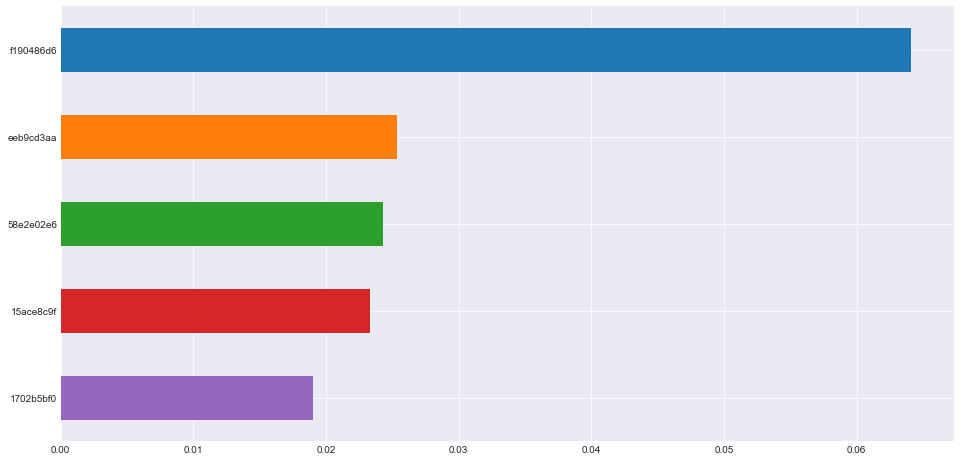

In [172]:
feat_importances_gb = pd.Series(clf_gb.feature_importances_, index=train_X.columns)
feat_importances_gb_top5 = feat_importances_gb.nlargest(5)
plt.figure(figsize=(16,8))
feat_importances_gb_top5.plot(kind='barh')
plt.gca().invert_yaxis()

In [173]:
feat_importances_gb.nlargest(1000).index

Index(['f190486d6', 'eeb9cd3aa', '58e2e02e6', '15ace8c9f', '1702b5bf0',
       '9fd594eec', '6eef030c1', '58232a6fb', 'c47340d97', '58e056e12',
       ...
       '7950f4c11', 'b2790ef54', '906d4316d', '3c6980c42', '2a3763e18',
       'f4e855860', '4b2316bd5', '298db341e', '01fdd93d3', '9ca9e4916'],
      dtype='object', length=1000)

In [146]:
train_X['target'] = y_train

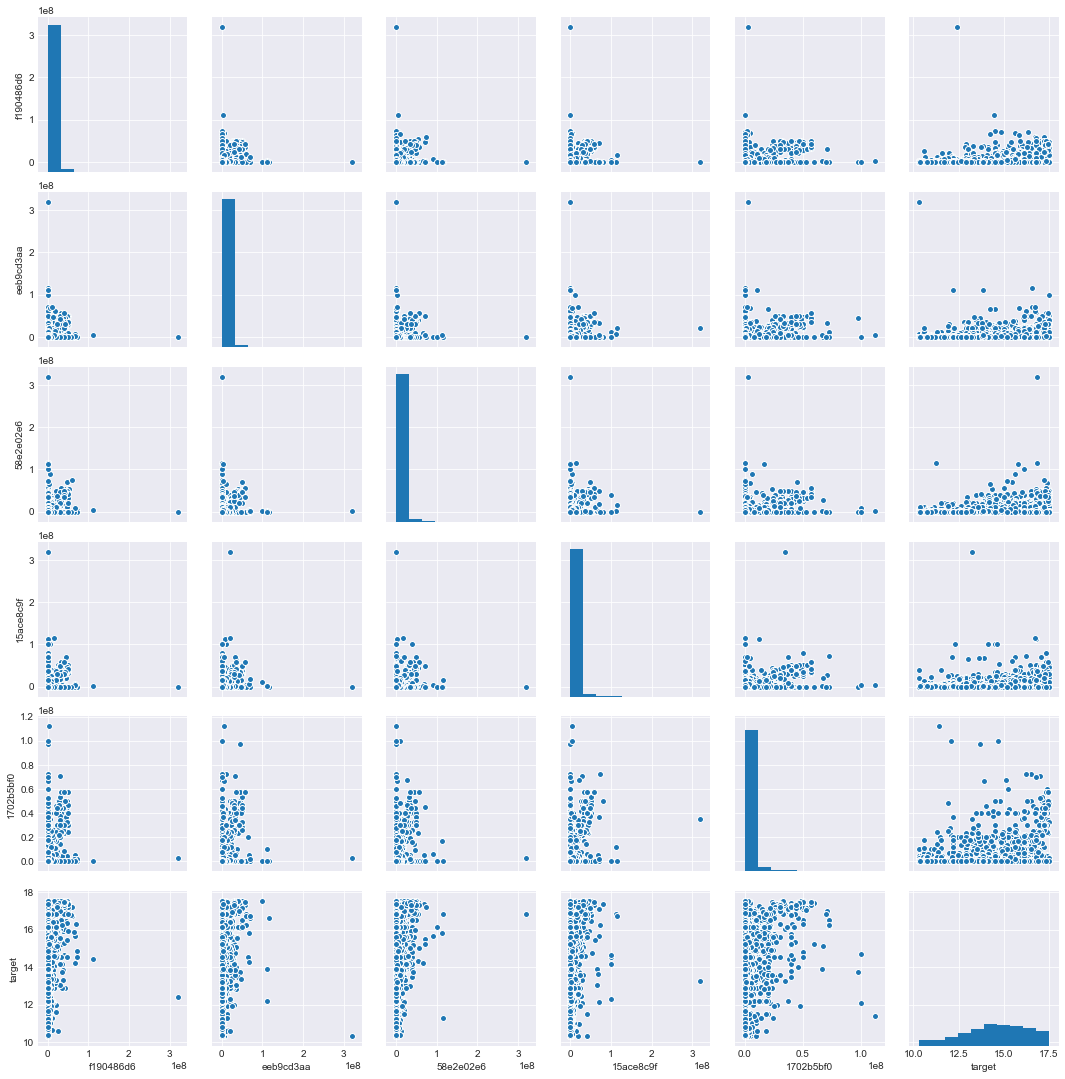

In [147]:
sns.pairplot(train_X[['f190486d6', 'eeb9cd3aa', '58e2e02e6', '15ace8c9f', '1702b5bf0','target']])

In [148]:
del train_X['target']

# K-Means

In [27]:
flist = [x for x in train_X_scaled.columns if not x in ['ID','target']]

flist_kmeans = []
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(train_X_scaled[flist].values)
    train_X_scaled['kmeans_cluster_'+str(ncl)] = cls.predict(train_X_scaled[flist].values)
    test_X_scaled['kmeans_cluster_'+str(ncl)] = cls.predict(test_X_scaled[flist].values)
    flist_kmeans.append('kmeans_cluster_'+str(ncl))
print(flist_kmeans)

['kmeans_cluster_2', 'kmeans_cluster_3', 'kmeans_cluster_4', 'kmeans_cluster_5', 'kmeans_cluster_6', 'kmeans_cluster_7', 'kmeans_cluster_8', 'kmeans_cluster_9', 'kmeans_cluster_10']


# PCA

In [28]:
def _get_number_components(model, threshold):
    component_variance = model.explained_variance_ratio_
    explained_variance = 0.0
    components = 0

    for var in component_variance:
        explained_variance += var
        components += 1
        if(explained_variance >= threshold):
            break
    return components

### Get the optimal number of components
pca = PCA()
train_pca = pca.fit_transform(train_X_scaled)
components = _get_number_components(pca, threshold=0.85)
components

994

In [29]:
components = 10

In [30]:
pca = PCA(n_components=components)
pca.fit(train_X_scaled)
train_X_pca = pca.transform(train_X_scaled)
test_X_pca = pca.transform(train_X_scaled)

In [31]:
train_X_pca = pd.DataFrame(data=train_X_pca)
test_X_pca = pd.DataFrame(data=test_X_pca)

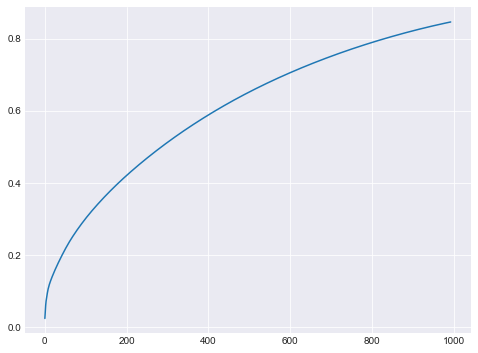

In [21]:
var = pca.explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(var))

Text(0,0.5,'Third Principal Component')

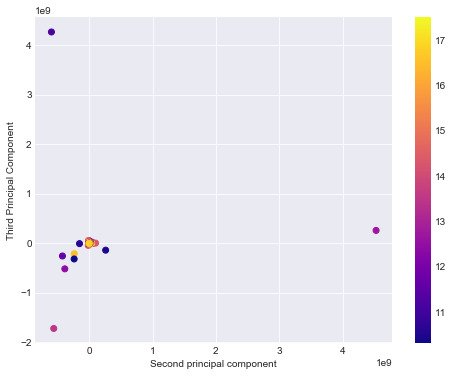

In [321]:
plt.figure(figsize=(8,6))
plt.scatter(train_X_pca[:,1],train_X_pca[:,2],cmap='plasma',c=y_train)
plt.colorbar()
plt.xlabel('Second principal component')
plt.ylabel('Third Principal Component')

[]

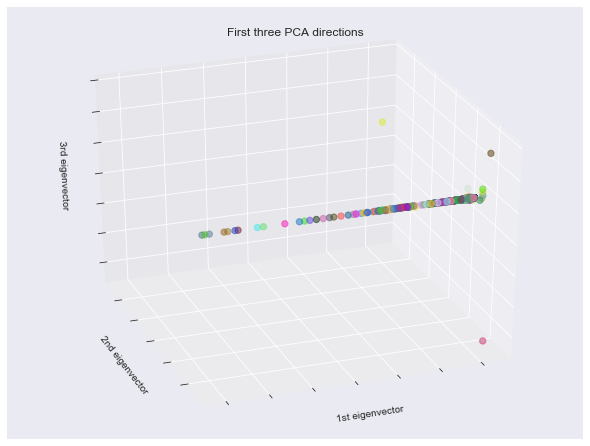

In [309]:
colors = np.random.random((4459, 3))

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=colors,
           cmap=plt.cm.Set1, edgecolor=colors, alpha=0.5, s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


# Truncated SVD

In [32]:
### Implement Truncated SVD 
obj_svd = TruncatedSVD(n_components = components)
train_X_svd = obj_svd.fit_transform(train_X_scaled)
test_X_svd = obj_svd.transform(test_X_scaled)

In [33]:
train_X_svd = pd.DataFrame(data=train_X_svd)
test_X_svd = pd.DataFrame(data=test_X_svd)

# FastICA

In [34]:
### Implement ICA 
ica = FastICA(n_components = components)
train_X_ica = ica.fit_transform(train_X_scaled)
test_X_ica = ica.transform(test_X_scaled)
train_X_ica = pd.DataFrame(data=train_X_ica)
test_X_ica = pd.DataFrame(data=test_X_ica)

# Factor Anaylsis

In [35]:
### Implement FA
fa = FactorAnalysis(n_components = components)
train_X_fa = fa.fit_transform(train_X_scaled)
test_X_fa = fa.transform(test_X_scaled)
train_X_fa = pd.DataFrame(data=train_X_fa)
test_X_fa = pd.DataFrame(data=test_X_fa)

# Gaussian Random Projection

In [36]:
grp = GaussianRandomProjection(n_components = components, eps = 0.1)
train_X_grp = grp.fit_transform(train_X_scaled)
test_X_grp = grp.transform(test_X_scaled)
train_X_grp = pd.DataFrame(data=train_X_grp)
test_X_grp = pd.DataFrame(data=test_X_grp)

# Sparse Random Projection

In [37]:
srp = SparseRandomProjection(n_components = components, eps = 0.1)
train_X_srp = srp.fit_transform(train_X_scaled)
test_X_srp = srp.transform(test_X_scaled)
train_X_srp = pd.DataFrame(data=train_X_srp)
test_X_srp = pd.DataFrame(data=test_X_srp)

# Add Decomposed Sets to Original Set

In [38]:
train_decomp = train_X_scaled.copy()
test_decomp = test_X_scaled.copy()

In [39]:
#https://www.kaggle.com/shivamb/dataset-decomposition-techniques

def _add_decomposition(df, decomp, ncomp, flag):
    for i in range(1, ncomp+1):
        df[flag+"_"+str(i)] = decomp.iloc[:, i - 1]

_add_decomposition(train_decomp, train_X_pca, components, 'pca')
_add_decomposition(test_decomp, test_X_pca, components, 'pca')

_add_decomposition(train_decomp, train_X_svd, components, 'svd')
_add_decomposition(test_decomp, test_X_svd, components, 'svd')

_add_decomposition(train_decomp, train_X_ica, components, 'ica')
_add_decomposition(test_decomp, test_X_ica, components, 'ica')

_add_decomposition(train_decomp, train_X_fa, components, 'fa')
_add_decomposition(test_decomp, test_X_fa, components, 'fa')

_add_decomposition(train_decomp, train_X_grp, components, 'grp')
_add_decomposition(test_decomp, test_X_grp, components, 'grp')

_add_decomposition(train_decomp, train_X_srp, components, 'srp')
_add_decomposition(test_decomp, test_X_srp, components, 'srp')

In [40]:
print("Train set decomp size: {}".format(train_decomp.shape))
print("Test set decomp size: {}".format(test_decomp.shape))

Train set decomp size: (4459, 4813)
Test set decomp size: (49342, 4813)


# Feature Selection

In [42]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed)
rfr.fit(train_decomp, y_train)
importances = rfr.feature_importances_

## get list of important features 
importances_df = pd.DataFrame({'importance': importances, 'feature': train_decomp.columns})
importances_df = importances_df.sort_values(by=['importance'], ascending=[False])

In [47]:
num_features = 250
important_features = importances_df[:num_features]['feature'].values

In [48]:
train_decomp[important_features].to_csv('train_250.csv', index=False)
test_decomp[important_features].to_csv('test_250.csv', index=False)

In [8]:
y_train_df = pd.DataFrame(data=y_train,columns=['target'])
print(y_train)
y_train_df.to_csv('y_train.csv',index=False)

[17.45309674 13.3046866  16.11809575 ... 14.84513033 16.11809575
 16.81124288]


In [41]:
train_decomp.to_csv('train_all_features.csv', index=False)
test_decomp.to_csv('test_all_features.csv', index=False)

# Modeling

In [44]:
def rmsle(y, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(y_pred - y, 2))), False

In [49]:
#split train/test into dev/val for lgb and xbg
dev_X, val_X, dev_y, val_y = train_test_split(train_decomp[important_features], 
                                              y_train, test_size = 0.2, 
                                              random_state = seed)

# Averaging Models 

In [48]:
NUM_FOLDS = 5 #need tuned
def rmsle_cv(model):
    kf = KFold(NUM_FOLDS, shuffle=True, random_state=seed).get_n_splits(train_decomp[important_features].values)
    rmse= np.sqrt(-cross_val_score(model, train_decomp[important_features], y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#ensemble method: model averaging
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    # the reason of clone is avoiding affect the original base models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]  
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([ model.predict(X) for model in self.models_ ])
        return np.mean(predictions, axis=1)
    
#ensemble method 2: staking models
class StackedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.055, colsample_bylevel =0.5, 
                             gamma=1.5, learning_rate=0.02, max_depth=32, 
                             objective='reg:linear',booster='gbtree',
                             min_child_weight=57, n_estimators=1000, reg_alpha=0, 
                             reg_lambda = 0,eval_metric = 'rmse', subsample=0.7, 
                             silent=1, n_jobs = -1, early_stopping_rounds = 14,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=40,
                              learning_rate=0.005, n_estimators=1000, max_depth=13,
                              metric='rmse',is_training_metric=True,
                              max_bin = 55, bagging_fraction = 0.7,verbose=-1,
                              bagging_freq = 5, feature_fraction = 0.6) 

model_cb = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = seed,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
score = rmsle_cv(model_cb)
print("CatBoost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

averaged_models = AveragingModels(models = (model_xgb, model_lgb, model_cb))
score = rmsle_cv(averaged_models)
print("averaged score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

'''
stacked_models = StackedModels(base_models = (model_xgb, model_lgb))
score = rmsle_cv(stacked_models)
print("stacked score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
'''

Xgboost score: 0.8643 (0.0491)

LGBM score: 0.6886 (0.0565)

0:	learn: 13.8785304	total: 4.8s	remaining: 39m 56s
50:	learn: 1.7138129	total: 3m 56s	remaining: 34m 44s
100:	learn: 0.9905227	total: 7m 52s	remaining: 31m 6s
150:	learn: 0.9764789	total: 11m 10s	remaining: 25m 50s
200:	learn: 0.8483427	total: 13m 3s	remaining: 19m 25s
250:	learn: 0.7110755	total: 15m 22s	remaining: 15m 15s
300:	learn: 0.6938801	total: 17m 50s	remaining: 11m 47s
350:	learn: 0.6777808	total: 20m 22s	remaining: 8m 38s
400:	learn: 0.6712794	total: 22m 57s	remaining: 5m 40s
450:	learn: 0.6639791	total: 25m 30s	remaining: 2m 46s
499:	learn: 0.6595347	total: 28m 4s	remaining: 0us
0:	learn: 13.9151991	total: 2.85s	remaining: 23m 44s
50:	learn: 1.7195646	total: 2m 51s	remaining: 25m 9s
100:	learn: 0.9690558	total: 5m 9s	remaining: 20m 21s
150:	learn: 0.9392060	total: 7m 21s	remaining: 16m 59s
200:	learn: 0.8300815	total: 9m 33s	remaining: 14m 13s
250:	learn: 0.7255596	total: 11m 46s	remaining: 11m 41s
300:	learn: 0.

'\nstacked_models = StackedModels(base_models = (model_xgb, model_lgb))\nscore = rmsle_cv(stacked_models)\nprint("stacked score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))\n'

In [49]:
averaged_models.fit(train_decomp[important_features].values, y_train)
pred = np.expm1(averaged_models.predict(test_decomp[important_features].values))
ensemble = pred

sub = pd.read_csv('sample_submission.csv')
sub["target"] = ensemble
print(sub.head())
sub.to_csv('sub_lgb.csv', index=False)

0:	learn: 13.8938561	total: 2.65s	remaining: 22m 2s
50:	learn: 1.6764221	total: 2m 28s	remaining: 21m 49s
100:	learn: 0.9112943	total: 5m 12s	remaining: 20m 33s
150:	learn: 0.8876557	total: 7m 53s	remaining: 18m 13s
200:	learn: 0.8854948	total: 10m 23s	remaining: 15m 27s
250:	learn: 0.6960113	total: 12m 58s	remaining: 12m 51s
300:	learn: 0.6803118	total: 15m 32s	remaining: 10m 16s
350:	learn: 0.6681705	total: 18m 4s	remaining: 7m 40s
400:	learn: 0.6575037	total: 20m 41s	remaining: 5m 6s
450:	learn: 0.6352770	total: 23m 13s	remaining: 2m 31s
499:	learn: 0.6253309	total: 25m 42s	remaining: 0us
          ID        target
0  000137c73  1.582360e+06
1  00021489f  3.050900e+06
2  0004d7953  1.632035e+06
3  00056a333  3.181170e+06
4  00056d8eb  2.945102e+06


# Light GBM

In [50]:
#Gridsearch tuning 

params_fixed = {
        "objective" : "regression",
        "metric" : "rmse",
        "bagging_seed" : seed,
        "verbosity" : -1,
        "seed": seed,
}

estimator = lgb.LGBMRegressor(**params_fixed)

params_grid = {
    'learning_rate': [0.005,0.0055,0.0045,0.003],  
    "num_leaves" : [40,50,55,60],
    "bagging_frequency" : [4,5,6],
    "bagging_fraction" : [0.7,0.6,0.5],
    "feature_fraction" : [0.5,0.6,0.4],

}

grid = GridSearchCV(estimator, params_grid, verbose = 100)

grid.fit(train_decomp[important_features], y_train)

print('Best parameters found by grid search are:', grid.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40, score=0.47928788617877793, total=   5.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40, score=0.4993504196892499, total=   4.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40, score=0.4792013470660149, total=   5.0s
[Parallel(n_jobs

[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40, score=0.46687320397298976, total=   4.7s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  2.4min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40, score=0.4479673130880442, total=   4.7s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.5min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=50, score=0.4488436375724568, total=   5.5s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  2.6min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leave

[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=40, score=0.4977763640280677, total=   5.1s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  4.8min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.495227601624153, total=   5.9s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  4.9min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.5177275637061243, total=   5.7s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  5.0min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[C

[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.4633887380927223, total=   6.3s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  7.4min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.4847715086602029, total=   6.4s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  7.5min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.4663401865146905, total=   6.7s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  7.6min remaining:    0.0s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0045, num_leaves

[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50, score=0.47550154817675216, total=   5.2s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50, score=0.4550373721810354, total=   5.1s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=55, score=0.4660907430562178, total=   5.6s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=55, score=0.4758558144941466, total=   5.3s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, nu

[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40, score=0.3289967595247535, total=   4.3s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40, score=0.3151736340661597, total=   4.3s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=50, score=0.324880185357333, total=   4.8s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=50, score=0.33022386624898925, total=   4.8s
[CV] bagging_fraction=0.7, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num

[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60, score=0.5305500528389862, total=   5.8s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60, score=0.5091683378462133, total=   6.0s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40, score=0.44821995935549364, total=   4.7s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0045, num_leaves=40, score=0.46687320397298976, total=   4.7s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.5, learning_rate=0

[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55, score=0.5178904360021617, total=   6.2s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55, score=0.4984352886073255, total=   6.1s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=60, score=0.4958378270135868, total=   6.2s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=60, score=0.5181270684393289, total=   6.2s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num

[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50, score=0.3649927768731537, total=   5.8s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50, score=0.3514533658547735, total=   5.8s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=55, score=0.34857987250361, total=   6.2s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=55, score=0.365124846170646, total=   6.4s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_le

[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40, score=0.4422196337340897, total=   4.6s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40, score=0.42357968267041923, total=   4.6s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=50, score=0.435133891620203, total=   5.3s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=50, score=0.44341290457579685, total=   5.2s
[CV] bagging_fraction=0.7, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.

[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60, score=0.5004905641021148, total=   6.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60, score=0.48035864806912865, total=   6.4s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.0055, num_leaves=40, score=0.5079808423026893, total=   5.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.0055, num_leaves=40, score=0.5292106879957741, total=   5.1s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005

[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55, score=0.3506073936495151, total=   6.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55, score=0.3364556354589118, total=  10.2s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=60, score=0.33643119801712795, total=   6.7s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=60, score=0.3508544859116186, total=   6.1s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, nu

[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.4847715086602029, total=   6.6s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.4663401865146905, total=   6.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=55, score=0.46355064490821474, total=   6.2s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=55, score=0.48475203553373747, total=   6.5s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.6, learning_rate=0

[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40, score=0.5037103229472786, total=   5.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40, score=0.482242193362243, total=   4.7s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=50, score=0.49451848437189905, total=   5.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=50, score=0.5046913431137401, total=   5.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0

[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60, score=0.3309000628821759, total=   6.0s
[CV] bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.7, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60, score=0.31635691820300116, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40, score=0.4770845635568633, total=   4.6s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, num_leaves=40, score=0.4991287896180711, total=   5.2s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.005, nu

[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55, score=0.4673738208618212, total=   7.2s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55, score=0.44798745313553145, total=   8.0s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=60, score=0.4469447826049603, total=   7.9s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=60, score=0.4673958635682358, total=   6.2s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.

[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50, score=0.5472290921222511, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50, score=0.5249535979221169, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=55, score=0.5230782094557891, total=   5.7s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=55, score=0.5472802786395037, total=   5.8s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0

[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40, score=0.47368241627759644, total=   4.2s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40, score=0.45279576530786336, total=   4.1s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50, score=0.46442564397079034, total=   4.6s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=50, score=0.4750005554480553, total=   4.6s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, 

[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60, score=0.4436242301094424, total=   5.1s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60, score=0.42349451381705927, total=   4.9s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40, score=0.32230278888559294, total=   4.1s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.003, num_leaves=40, score=0.32815433035848296, total=   4.2s
[CV] bagging_fraction=0.6, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.00

[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55, score=0.5299564958617411, total=   5.7s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55, score=0.5077523033280457, total=   5.3s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60, score=0.5070835846717829, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=60, score=0.5300755308894375, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0

[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.5172491077812171, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.49639631109291543, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55, score=0.4942324777828947, total=   5.7s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=55, score=0.5172405623167167, total=   6.0s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, nu

[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40, score=0.3640113799681902, total=   5.0s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40, score=0.349281867526275, total=   4.9s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50, score=0.34743213505042825, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=50, score=0.3644572343562825, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num

[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60, score=0.504361454351183, total=   4.9s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60, score=0.48259051537481557, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40, score=0.43275444639893923, total=   4.1s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0045, num_leaves=40, score=0.4415598274392589, total=   4.1s
[CV] bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.

[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55, score=0.5000006757442332, total=   5.3s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55, score=0.4791484049692481, total=   5.3s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60, score=0.47834860678541957, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=60, score=0.5001399212195939, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, nu

[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50, score=0.3497921723456424, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50, score=0.33518519248223666, total=   5.1s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55, score=0.33449572255096616, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=55, score=0.3500968273281637, total=   5.2s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, n

[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40, score=0.48380068885180944, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40, score=0.4642274608881772, total=   4.9s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.46199981082780145, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=50, score=0.48414316334812746, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, learning_rate=

[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60, score=0.4753844583925767, total=   4.7s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60, score=0.4540871705394342, total=   5.5s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40, score=0.49204156398463467, total=   4.5s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.0055, num_leaves=40, score=0.5027836100564952, total=   4.2s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005

[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55, score=0.3297623738919373, total=   5.1s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55, score=0.3146635601329488, total=   5.4s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60, score=0.3235906078716785, total=   5.2s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=60, score=0.32994667738107275, total=   5.3s
[CV] bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, nu

[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=50, score=0.46577953368019065, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=50, score=0.446272658389494, total=   4.3s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55, score=0.4454823080128366, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.0045, num_leaves=55, score=0.46581937592421463, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.5, learning_rate=0.

[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=40, score=0.545158961220475, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=40, score=0.523710917873093, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50, score=0.5206797363093489, total=   4.7s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.0055, num_leaves=50, score=0.5454596967446049, total=   4.8s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.005

[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.003, num_leaves=60, score=0.3629790677905006, total=   5.0s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.003, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.6, learning_rate=0.003, num_leaves=60, score=0.34941750087963097, total=   5.0s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40, score=0.46095018040834623, total=   3.7s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, num_leaves=40, score=0.4713118368140287, total=   3.7s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.005, n

[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=55, score=0.44070321946354696, total=   4.1s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=55, score=0.42185354085935867, total=   4.2s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60, score=0.4307776565328104, total=   4.2s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0.0045, num_leaves=60, score=0.4407021855241463, total=   4.7s
[CV] bagging_fraction=0.5, bagging_frequency=4, feature_fraction=0.4, learning_rate=0

[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=50, score=0.5286537484957057, total=   4.6s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=50, score=0.5067604260232171, total=   4.3s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55, score=0.5059208310986274, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0055, num_leaves=55, score=0.5285507074462412, total=   4.7s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.5, learning_rate=0.0

[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=40, score=0.5149295261479784, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=40, score=0.4948437865259562, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.4916520092257202, total=   4.7s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num_leaves=50, score=0.5152566426253028, total=   4.7s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.005, num

[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.0045, num_leaves=60, score=0.4822052823407899, total=   5.1s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.0045, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.0045, num_leaves=60, score=0.4634792488090171, total=   5.5s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40, score=0.34522985152687324, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, num_leaves=40, score=0.362510167346915, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.6, learning_rate=0.003, 

[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=55, score=0.5023900980572472, total=   4.1s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=55, score=0.480645126813474, total=   4.1s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60, score=0.4900446897580699, total=   4.3s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.0055, num_leaves=60, score=0.5022355368729932, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=5, feature_fraction=0.4, learning_rate=0.00

[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=50, score=0.4985394768142755, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=50, score=0.47732729343447183, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55, score=0.47707338553147416, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, num_leaves=55, score=0.4982574350632155, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.005, n

[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=40, score=0.34789587218997053, total=   4.2s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=40, score=0.33345019804263665, total=   4.2s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50, score=0.33304023151737605, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, num_leaves=50, score=0.3484039364924971, total=   4.8s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.5, learning_rate=0.003, 

[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0055, num_leaves=60, score=0.5455038670105317, total=   5.1s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0055, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0055, num_leaves=60, score=0.5242999615625763, total=   5.1s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40, score=0.4595483180383506, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0045, num_leaves=40, score=0.4817819746781765, total=   4.5s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.6, learning_rate=0.0

[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=55, score=0.47269967386994854, total=   4.1s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=55, score=0.45233542478066796, total=   4.3s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60, score=0.4617078701952825, total=   4.3s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, num_leaves=60, score=0.4726866335476998, total=   4.6s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.005, n

[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=50, score=0.3279551917353667, total=   4.0s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=50, score=0.31293308207557147, total=   4.4s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55, score=0.32102361846686167, total=   4.2s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55 
[CV]  bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, num_leaves=55, score=0.32808917898872525, total=   4.1s
[CV] bagging_fraction=0.5, bagging_frequency=6, feature_fraction=0.4, learning_rate=0.003, 

In [50]:
#Run model with best params 0.669454 (decomp, agg, leak, std scalin) 750, 20 components

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : seed,
        "verbosity" : -1,
        "seed": seed
    }
    
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result,
                      )
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [51]:
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_decomp[important_features])
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.45782
[100]	valid_0's rmse: 1.25247
[150]	valid_0's rmse: 1.0929
[200]	valid_0's rmse: 0.967938
[250]	valid_0's rmse: 0.884513
[300]	valid_0's rmse: 0.824522
[350]	valid_0's rmse: 0.781586
[400]	valid_0's rmse: 0.7538
[450]	valid_0's rmse: 0.733313
[500]	valid_0's rmse: 0.718945
[550]	valid_0's rmse: 0.709195
[600]	valid_0's rmse: 0.702673
[650]	valid_0's rmse: 0.697751
[700]	valid_0's rmse: 0.693725
[750]	valid_0's rmse: 0.691118
[800]	valid_0's rmse: 0.689475
[850]	valid_0's rmse: 0.687641
[900]	valid_0's rmse: 0.686225
[950]	valid_0's rmse: 0.684739
[1000]	valid_0's rmse: 0.683608
[1050]	valid_0's rmse: 0.682518
[1100]	valid_0's rmse: 0.681452
[1150]	valid_0's rmse: 0.680131
[1200]	valid_0's rmse: 0.679318
[1250]	valid_0's rmse: 0.678445
[1300]	valid_0's rmse: 0.678163
[1350]	valid_0's rmse: 0.677959
[1400]	valid_0's rmse: 0.677443
[1450]	valid_0's rmse: 0.677328
[1500]	valid_0's rmse: 0.677272
[15

In [128]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:15])

Features Importance...
         feature       gain  split
0           leak  45.269132   4174
1       log_leak  28.036164   2984
3            Max   2.189767    837
5       SumZeros   1.912530   1485
2            Var   1.112525    756
6   weight_count   1.001365   1179
7      SumValues   0.957131    787
29          fa_9   0.872028    579
4            Std   0.837950    435
10          fa_6   0.738635    873
30         ica_4   0.603626    708
11    count_not0   0.597820    411
33         svd_2   0.588314    659
22         ica_7   0.578773    899
15         svd_1   0.538195    740


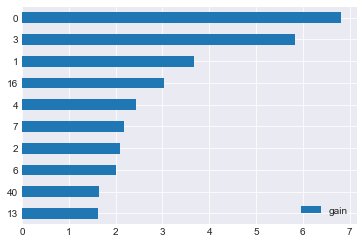

In [215]:
plt.figure(figsize=(16,8))
featureimp[['feature','gain']][:10].plot(kind='barh')
plt.gca().invert_yaxis()

# XGBoost

In [206]:
#XGBoost rmse 2.332

def run_xgb(train_X, train_y, val_X, val_y, test_X):
    
    params = {'objective': 'reg:linear', 
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10, 
              'subsample': 0.6, 
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': seed, 
              'silent': True
             }
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [207]:
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, test_decomp[important_features])
print("XGB Training Completed...")

[0]	train-rmse:14.0964	valid-rmse:14.0416
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:12.7745	valid-rmse:12.7195
[200]	train-rmse:11.5803	valid-rmse:11.5257
[300]	train-rmse:10.5013	valid-rmse:10.4471
[400]	train-rmse:9.52634	valid-rmse:9.47331
[500]	train-rmse:8.64551	valid-rmse:8.59409
[600]	train-rmse:7.85018	valid-rmse:7.80098
[700]	train-rmse:7.13155	valid-rmse:7.08555
[800]	train-rmse:6.48315	valid-rmse:6.44083
[900]	train-rmse:5.89787	valid-rmse:5.86033
[1000]	train-rmse:5.36985	valid-rmse:5.33805
[1100]	train-rmse:4.89324	valid-rmse:4.86778
[1200]	train-rmse:4.46314	valid-rmse:4.44511
[1300]	train-rmse:4.07524	valid-rmse:4.06593
[1400]	train-rmse:3.7253	valid-rmse:3.72584
[1500]	train-rmse:3.40926	valid-rmse:3.42162
[1600]	train-rmse:3.12454	valid-rmse:3.15076
[1700]	train-rmse:2.86797	valid-rmse:2.90907
[1800]	train-rmse:2.63669	valid-rmse:2.6946
[1900]	train-

# Validate on Train Set

In [208]:
#lightgbm
lgbm_pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)

#xgboost
dtest = xgb.DMatrix(val_X)
xgb_pred_val_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)

print('LGBM VAL: {}'.format(rmsle(val_y, lgbm_pred_val_y)))
print('XBG RMSE: {}'.format(rmsle(val_y, xgb_pred_val_y)))

combined = lgbm_pred_val_y*0.9 + xgb_pred_val_y*0.1

print('Combined RMSE: {}'.format(rmsle(val_y, combined)))

LGBM VAL: ('RMSLE', 1.2991312735948, False)
XBG RMSE: ('RMSLE', 2.3385483562421014, False)
Combined RMSE: ('RMSLE', 1.309975781230449, False)


# Submit Ensemble

In [125]:
#Merge models
ensemble = pred_test#*0.9 + pred_test_xgb*0.1

In [126]:
sub = pd.read_csv('sample_submission.csv')
sub["target"] = ensemble
print(sub.head())
sub.to_csv('sub_lgb.csv', index=False)

          ID        target
0  000137c73  1.420018e+06
1  00021489f  2.146963e+06
2  0004d7953  2.487325e+06
3  00056a333  2.443827e+06
4  00056d8eb  3.080884e+06
